<a href="https://colab.research.google.com/github/dc3347/CompAspectsofRobotics/blob/main/Robotics_HW_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
COMS 4733 Spring 2021 Homework 3
Scaffolding code for building a PRM for RR arm motion planning
Portions gratefully taken from the PythonRobotics project
https://pythonrobotics.readthedocs.io/en/latest/
"""

import random
import math
import numpy as np
import numpy.linalg as nla
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

In [ ]:
"""
Robot and PRM parameters
"""
# Simulation environment
OBSTACLES = [[1.75, 0.75, 0.6], [-.5, 1.5, 0.5], [0, -1, 0.7]] # circular obstacles [x, y, r]
#OBSTACLES = [[1.75, 0.75, 0.6], [-.55, 1.5, 0.5], [0, -1, 0.7], [-2, -0.5, 0.6]]
LINK_LENGTH = [1, 1] # lengths of arm links
START = (1.0, 0.0) # start joint configuration
# START = (-3.0, 1.0)
GOAL = (-3.0, -1.0) # goal joint configuration
# GOAL = (-0.5, 0.5)

# PRM parameters
N_SAMPLE = 100  # number of sample_points
N_KNN = 5  # number of neighbors to attempt to connect
MAX_EDGE_LEN = 2 #0.1  # [m] Maximum edge length


In [ ]:
"""
Classes for an n-link arm and a graph node for search
"""
class NLinkArm(object):
    """
    Class for controlling and plotting a planar arm with an arbitrary number of links.
    """

    def __init__(self, link_lengths, joint_angles):
        self.n_links = len(link_lengths)
        if self.n_links != len(joint_angles):
            raise ValueError()

        self.link_lengths = np.array(link_lengths)
        self.joint_angles = np.array(joint_angles)
        self.points = [[0, 0] for _ in range(self.n_links + 1)]

        self.lim = sum(link_lengths)
        self.update_points()

    def update_joints(self, joint_angles):
        self.joint_angles = np.array(joint_angles)
        self.update_points()

    def update_points(self):
        for i in range(1, self.n_links + 1):
            self.points[i][0] = self.points[i - 1][0] + \
                self.link_lengths[i - 1] * \
                np.cos(np.sum(self.joint_angles[:i]))
            self.points[i][1] = self.points[i - 1][1] + \
                self.link_lengths[i - 1] * \
                np.sin(np.sum(self.joint_angles[:i]))

        self.end_effector = np.array(self.points[self.n_links]).T

class Node:
    """
    Node class for dijkstra search
    """

    def __init__(self, x, y, cost, parent_index):
        self.x = x
        self.y = y
        self.cost = cost
        self.parent_index = parent_index

    def __str__(self):
        return str(self.x) + "," + str(self.y) + "," +\
               str(self.cost) + "," + str(self.parent_index)


In [ ]:
"""
Potentially useful utility functions
"""
def detect_collision(arm, obstacles, config):
    """
    :param arm: NLinkArm object
    :param obstacles: List of circular obstacles
    :param config: Configuration (joint angles) of the arm
    :return: True if any part of arm collides with obstacles, False otherwise
    """
    arm.update_joints(config)
    points = arm.points
    for k in range(len(points) - 1):
        for circle in obstacles:
            a_vec = np.array(points[k])
            b_vec = np.array(points[k+1])
            c_vec = np.array([circle[0], circle[1]])
            radius = circle[2]

            line_vec = b_vec - a_vec
            line_mag = np.linalg.norm(line_vec)
            circle_vec = c_vec - a_vec
            proj = circle_vec.dot(line_vec / line_mag)

            if proj <= 0:
                closest_point = a_vec
            elif proj >= line_mag:
                closest_point = b_vec
            else:
                closest_point = a_vec + line_vec * proj / line_mag

            if np.linalg.norm(closest_point - c_vec) <= radius:
                return True

    return False


def toroid_to_euclidean_points(x, y):
    """
    :param x, y: Two 2D vectors in toroidal space
    :return: x, y', where x is identical to the first input and y' is Euclidean equivalent of y closest to x
    """
    A = np.meshgrid([-1,0,1], [-1,0,1])
    y_set = y + 2*np.pi*np.array(A).T.reshape(-1,2)
    ind = np.argmin(nla.norm(y_set-x, axis=1))
    return x, y_set[ind]


def torus_dist(x,y):
    """
    Distance metric on toroidal space
    """
    x, yp = toroid_to_euclidean_points(x,y)
    return nla.norm(yp-x)


#test
config= toroid_to_euclidean_points((0,-math.pi),(0,math.pi-0.1))
#toroid_to_euclidean_points((0,0),(1,1))
arm = NLinkArm(LINK_LENGTH, [0,0])
detect_collision(arm, OBSTACLES, ((0,-1),(0,1)))
#toroid_to_euclidean_points(0,-math.pi)
#toroid_to_euclidean_points(0,math.pi-0.1)


True

In [ ]:
"""
PRM construction and search
"""
def plan_route(arm, obstacles, sx, sy, gx, gy):
    sample_x, sample_y = sample_points(arm, obstacles, sx, sy, gx, gy)
    roadmap = construct_prm(arm, obstacles, sample_x, sample_y)
    rx, ry = dijkstra(sx, sy, gx, gy, roadmap, sample_x, sample_y)
    return roadmap, sample_x, sample_y, list(zip(rx,ry))


# WRITE THIS FUNCTION, 4.1
def sample_points(arm, obstacles, sx, sy, gx, gy):
    """
    :param arm, obstacles: NLinkArm object, list of circular obstacles
    :param sx, sy: Start coordinates
    :param gx, gy: Goal coordinates
    :return: Two lists of sample x coordinates and y coordinates
    """
    sample_x = []
    sample_y = [] 

    x = np.random.uniform(-math.pi, math.pi, N_SAMPLE)
    y = np.random.uniform(-math.pi, math.pi, N_SAMPLE)

    # check to see if the point is on or inside an obstacle by seeing if dist to center <=radius
    intersect=False
    for i in range(0, len(x)):
      for elem in obstacles:
        radius = elem[2]
        dist = abs(torus_dist((x[i],elem[0]),(y[i],elem[1]))) #math.sqrt((x[i]-elem[0])**2+(y[i]-elem[1])**2)
        if dist<=radius:
          intersect=True
      if intersect==False:
        sample_x.append(x[i])
        sample_y.append(y[i])
      intersect = False
    
    
    #appends start and goal positions to second-to-last and last elements, respectively
    sample_x.append(sx)
    sample_x.append(gx)
    sample_y.append(sy) 
    sample_y.append(gy)

    return sample_x, sample_y


# WRITE THIS FUNCTION
def construct_prm(arm, obstacles, sample_x, sample_y):
    """
    :param arm, obstacles: NLinkArm object, list of circular obstacles
    :param sample_x, sample_y: n-lists of sample x and y coordinates
    :return: A roadmap n-list of lists. The ith list indicates all sample indices that are neighbors of the ith sample.
    """
    roadmap = [[i] for i in range(len(sample_x))] # list of lists
    samples = np.array([[sample_x[i], sample_y[i]] for i in range(0,len(sample_x))])

    n = NearestNeighbors(n_neighbors=N_KNN, radius=MAX_EDGE_LEN, metric=torus_dist).fit(samples)
    distances, indices = n.kneighbors(samples)

    # do collision check when incrementally creating edges
    for i in range(0, len(indices)):
      for j in range(0, len(indices[i])):
        c1 = samples[indices[i,0]]
        c2 = samples[indices[i,j]]

        # incremental collision detection, start at q1, move toward q2 in increments equal to step size, checking for collisions at each point
        config1,config2 = toroid_to_euclidean_points(c1,c2)
      
        # assuming step size is the same as the length btw the point and its neighbor
        
        if detect_collision(arm, obstacles, (config1, config2)) == False:
            roadmap[i].append(indices[i,j])
        '''

        collision = False
        step_size_x = torus_dist(config1[0], config2[0])/10
        step_size_y = torus_dist(config1[1], config2[1])/10
        
        while config1[0]!=config2[0] or config1[1]!=config2[1]:
          con = config1
          config_temp = (config1[0]+step_size_x, config1[1]+step_size_y)
  
          if detect_collision(arm, obstacles, (con, config_temp)) == True: # intersection with obstacle
            collision=True
            break
          config1 = config_temp

        if collision == False:
          roadmap[i].append(indices[i,j])
        '''
    print(roadmap)
    return roadmap


In [ ]:
"""
Dijkstra search for a path given start, goal, roadmap, sample points
"""
def dijkstra(sx, sy, gx, gy, road_map, sample_x, sample_y):

    start_node = Node(sx, sy, 0.0, -1)
    goal_node = Node(gx, gy, 0.0, -1)

    open_set, closed_set = dict(), dict()
    open_set[len(road_map) - 2] = start_node

    while True:
        if not open_set:
            return [], []

        c_id = min(open_set, key=lambda o: open_set[o].cost)
        current = open_set[c_id]

        if c_id == (len(road_map) - 1):
            goal_node.parent_index = current.parent_index
            goal_node.cost = current.cost
            break

        # Remove the item from the open set
        del open_set[c_id]
        # Add it to the closed set
        closed_set[c_id] = current

        # expand search grid based on motion model
        for i in range(len(road_map[c_id])):
            n_id = road_map[c_id][i]
            dx = sample_x[n_id] - current.x
            dy = sample_y[n_id] - current.y
            d = math.hypot(dx, dy)
            node = Node(sample_x[n_id], sample_y[n_id],
                        current.cost + d, c_id)

            if n_id in closed_set:
                continue
            # Otherwise if it is already in the open set
            if n_id in open_set:
                if open_set[n_id].cost > node.cost:
                    open_set[n_id].cost = node.cost
                    open_set[n_id].parent_index = c_id
            else:
                open_set[n_id] = node

    # generate final course
    rx, ry = [goal_node.x], [goal_node.y]
    parent_index = goal_node.parent_index
    while parent_index != -1:
        n = closed_set[parent_index]
        rx.append(n.x)
        ry.append(n.y)
        parent_index = n.parent_index

    return reversed(rx), reversed(ry)


In [ ]:
"""
Plotting and visualization functions
"""

def get_occupancy_grid(arm, obstacles, M):
    grid = [[0 for _ in range(M)] for _ in range(M)]
    theta_list = [2 * i * np.pi / M for i in range(-M // 2, M // 2 + 1)]
    for i in range(M):
        for j in range(M):
            grid[i][j] = int(detect_collision(arm, obstacles, [theta_list[i], theta_list[j]]))
    return np.array(grid)

def plot_road_map(ax, road_map, sample_x, sample_y):
    for i, _ in enumerate(road_map):
        for ii in range(len(road_map[i])):
            ind = road_map[i][ii]
            x, yp = toroid_to_euclidean_points([sample_x[i], sample_y[i]], [sample_x[ind], sample_y[ind]])
            y, xp = toroid_to_euclidean_points([sample_x[ind], sample_y[ind]], [sample_x[i], sample_y[i]])
            ax.plot([x[0], yp[0]], [x[1], yp[1]], "-k")
            ax.plot([xp[0], y[0]], [xp[1], y[1]], "-k")

def plot_arm(plt, ax, arm, obstacles):
    for obstacle in obstacles:
        circle = plt.Circle((obstacle[0], obstacle[1]), radius=0.5 * obstacle[2], fc='k')
        plt.gca().add_patch(circle)

    for i in range(arm.n_links + 1):
        if i is not arm.n_links:
            ax.plot([arm.points[i][0], arm.points[i + 1][0]], [arm.points[i][1], arm.points[i + 1][1]], 'r-')
        ax.plot(arm.points[i][0], arm.points[i][1], 'k.')

def visualize_spaces(arm, obstacles):
    plt.subplots(1, 2)

    plt.subplot(1, 2, 1)
    grid = get_occupancy_grid(arm, obstacles, 200)
    plt.imshow(np.flip(grid.T, axis=0))
    plt.xticks([0,50,100,150,200], ["-\u03C0", "-\u03C0/2", "0", "\u03C0/2", "\u03C0"])
    plt.yticks([0,50,100,150,200], ["\u03C0", "\u03C0/2", "0", "-\u03C0/2", "-\u03C0"])
    plt.title("Configuration space")
    plt.xlabel('joint 1')
    plt.ylabel('joint 2')

    ax = plt.subplot(1, 2, 2)
    arm.update_joints(START)
    plot_arm(plt, ax, arm, obstacles)
    plt.title("Workspace")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('scaled')
    plt.xlim(-3.0, 3.0)
    plt.ylim(-3.0, 3.0)
    plt.show()

def animate(arm, obstacles, road_map, sample_x, sample_y, route):
    ax1 = plt.subplot(1, 2, 1)
    plot_road_map(ax1, road_map, sample_x, sample_y)
    plt.plot(sample_x, sample_y, ".b")
    plt.plot(route[0][0], route[0][1], "Xc")
    plt.plot(route[-1][0], route[-1][1], "Xc")
    plt.title("Configuration space")
    plt.xlabel('joint 1')
    plt.ylabel('joint 2')
    plt.axis('scaled')
    plt.xlim(-3.2, 3.2)
    plt.ylim(-3.2, 3.2)

    ax2 = plt.subplot(1, 2, 2)
    arm.update_joints(START)
    plot_arm(plt, ax2, arm, obstacles)
    plt.title("Workspace")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('scaled')
    plt.xlim(-3.0, 3.0)
    plt.ylim(-3.0, 3.0)
    plt.pause(1)

    for i, node in enumerate(route):
        arm.update_joints([node[0], node[1]])
        ax1.plot(node[0], node[1], "xr")
        ax2.lines = []
        plot_arm(plt, ax2, arm, obstacles)
        # Uncomment here to save the sequence of frames
        # plt.savefig('frame{:04d}.png'.format(i))
        plt.pause(0.3)

    plt.show()

[[0, 0, 18, 46, 55, 20], [1, 1, 24, 68, 30, 40], [2], [3, 3, 100, 4], [4, 4, 6, 3], [5, 94, 21], [6], [7, 7, 73, 44, 83, 22], [8, 8, 72, 43, 62, 71], [9], [10, 10, 93, 78, 98], [11], [12, 12, 63, 79, 60, 57], [13, 13, 84, 32, 81, 28], [14, 14, 97, 54, 91], [15, 15, 25, 64, 49, 98], [16], [17], [18, 18, 50], [19, 19, 68, 24, 40, 1], [20, 20, 44, 55, 46, 7], [21, 21, 94, 59, 1, 61], [22, 22, 73], [23, 23, 95, 77, 65], [24, 24, 93], [25, 25, 64, 15, 29, 2], [26, 26, 28, 32, 84], [27, 95, 65], [28, 28, 32, 84, 13, 26], [29], [30, 30, 40, 61, 86, 1], [31, 31, 51, 42, 63, 69], [32, 32, 28, 84, 13, 81], [33, 33, 49, 41, 15, 27], [34], [35, 35, 67, 95, 65, 66], [36, 36, 80, 41, 0, 18], [37], [38], [39, 58], [40, 40, 30, 86, 61, 68], [41, 41, 49], [42, 31], [43], [44, 44, 55, 20, 46, 7], [45, 45, 101, 70, 59, 94], [46, 46, 0, 18, 55, 44], [47, 47, 73, 101, 45, 70], [48], [49, 49, 25, 15], [50, 50, 89, 66], [51, 51, 31, 63], [52], [53, 0, 54], [54, 97], [55, 55, 44, 20, 46, 7], [56], [57, 58], [

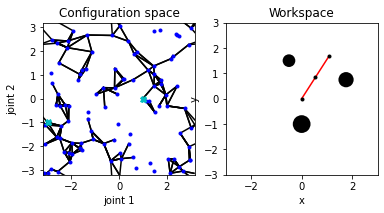

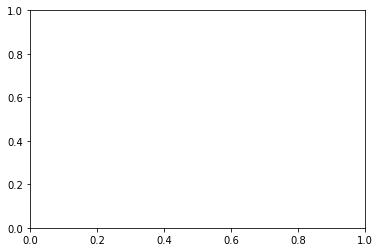

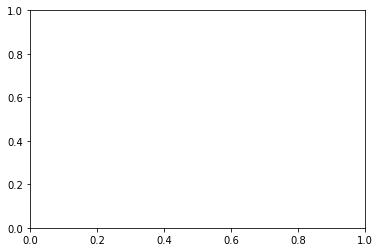

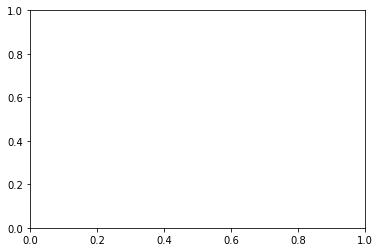

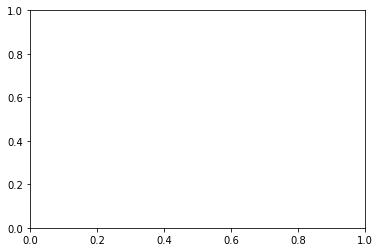

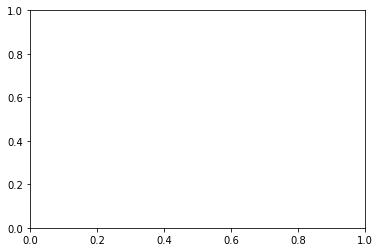

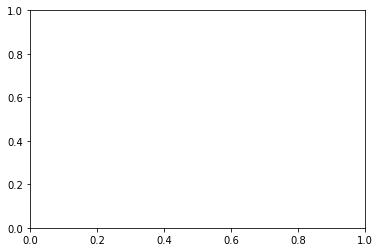

In [ ]:
"""
Main function
"""
def main():
    arm = NLinkArm(LINK_LENGTH, [0,0])
    # visualize_spaces(arm, OBSTACLES)
    roadmap, sample_x, sample_y, route = plan_route(arm, OBSTACLES, START[0], START[1], GOAL[0], GOAL[1])
    if not route:
        print("No path found!")
    animate(arm, OBSTACLES, roadmap, sample_x, sample_y, route)

if __name__ == '__main__':
    main()